In [13]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

# Bayesian Inference and Monte Carlo methods

This notebook introduces a Bayesian approach to model calibration and also presents the basics of how to use Monte Carlo (MC) methods to sample from difficult distributions.

## 1.1. A Bayesian model calibration framework

At the end of the first notebook we introduced Bayes' Theorem:

$$P(y \mid x) = \frac{P(x \mid y)P(y)}{\int_y P(x \mid y)P(y) dy}$$

and in the second notebook we discussed model auto-calibration, which led us to the concept of the likelihood function. 

In a typical calibration situtaion we have an environmental model that includes some poorly defined parameters, and we will also have observed data for the variable we're trying to simulate, together with contemporary observations for all the input datasets we need to run the model. We often also have some idea of roughly what values the parameters should take (e.g. from ranges in the literature), but we don't know enough about them to be able to use the model without calibrating it. 

There are lots of different ways of calibrating models, but here we're going to focus on the Bayesian approach. In this case, the aim of model calibration is to start off with whatever **prior information** we have about the parameters (e.g. literature values) and then **refine** these estimates using the observed data. If our model has $\theta =  \{\theta_1, .., \theta_n\}$ poorly constrained parameters, we can capture our **prior** beliefs by defining distributions for each of them. For example, in the simplest case we might define **uniform distributions** for each parameter with the maximum and minimum values for each distribution based upon literature ranges. The **joint distribution** over all the $\theta_i$ is the **prior distribution**, $P(\theta)$, of our parameters.

We want to take the prior distribution and *update* it based on the observed data. In other words, we want to calculate a new distribution for the parameters **given** the observations, $P(\theta \mid D)$, where $D$ is the observed data. This is called the **posterior distribution**, because it represents what we know about the parameters **after** we've incorporated the information from the observations. Once we have the posterior distribution, we can calculate **marginal posteriors** for each parameter, which we can compare to our prior distributions to see how much we've learned from the calibration process (see notebook 1 for a quick overview of marginalisation).

So, we want to calculate $P(\theta \mid D)$, but it's not immediately obvious how to do this. This is where Bayes' Theorem comes in. From the equation above, we can write:

$$P(\theta \mid D) = \frac{P(D \mid \theta)P(\theta)}{\int_y P(D \mid \theta)P(\theta) d\theta}$$

How does this help? Well, $P(\theta)$ is the prior distribution, which we already know. $P(D \mid \theta)$ is the probability of the observations, *given* a particular set of parameters. In other words, if we run the model with a particular set of parameters, what is the probabiltiy that it produces the observed data? From notebook 2, you should be able to see that this is the **likelihood function**. Working out the likelihood function can be tricky but, as we've seen previously, if you make some assumptions you can usually write it down. This gives us everything we need to work out the right-hand side of the equation above: the numerator in the fraction is the prior multiplied by the likelihood, and the denominator is the integral of the numerator over the entire parameter space. This integral is actually just a constant: it's a scaling factor which "normalises" the numerator so that the total volume under the posterior surface is equal to one. It is properly referred to as **the probability of the data** or, sometimes, as the **evidence**, but it's also often just called the **normalising constant**.

This means we can re-write Bayes' Theorem as:

$$posterior = \frac{likelihood \times prior}{normalising\;constant}$$

In principle, at least, Bayes' Theorem gives us everything we need to calculate $P(\theta \mid D)$. In practice, the integral in the denominator tends to be very tricky to evaluate because it frequently has no analytical solution. Also, because it involves integrating over the *entire* parameter space, numerical approximations of the integral are often very *expensive* to calculate (i.e. they take a long time to run). Fortunately, in many application we don't need to know the exact posterior distribution - anything *proportional* to it will do. Because the denominator in Bayes' equation is ultimately just a constant, we often ignore it and write:

$$P(\theta \mid D) \propto P(D \mid \theta)P(\theta)$$

$$posterior \propto likelihood \times prior$$

## 1.2. Conjugate priors

The difficulty of evaluating the posterior depends on the complexity of the prior distribution and likelihood function. If the likelihood is something simple, like a Gaussian, we can often make life easier for ourselves by choosing a **[conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)** to ensure that the posterior will also be a friendly function. 

Choosing your prior to make the calculations easier might seem a bit arbitrary, and in fact this is one area where the Bayesian approach often comes in for criticism. However it's worth emphasising that, regardless of whether you adopt a Bayesian or a Frequentist paradigm, **["you can't do inference without making assumptions"](http://www.inference.phy.cam.ac.uk/itila/ "Quote from page 51 of David MacKay's book")**. Clearly you should only choose a conjugate prior if it also makes sense based on what you know about your parameters, but if you have a choice between two reasonable-looking alternatives, one of which is conjugate, you might as well makes things as straightforward as possible.

Once we have the posterior distribution in a suitable form, we can calculate marginal distributions for each parameter by integrating. Recall from notebook 1 that for a two-dimensional joint distribution, $P(x,y)$, the marginal distribution for $x$ was obtained by "integrating out" $y$:

$$P(x) = \int_y P(x,y) dy$$

If our model has $n$ parameters, $\{\theta_1, .., \theta_n\}$, then the marginal distribution for each parameter is found by "integrating out" all the others.

## 1.3. Practical difficulties

We're not going to delve into the details of conjugate priors any further because for the purposes of calibrating complex models we won't find them very useful. This is because in most cases the likelihood function will not be a simple distribution for which an obvious conjugate prior exists. More often than not, the likelihood function will be something pretty horrible that makes the posterior density impossible to integrate analytically.

In general, when working with conceptual environmental models, we will often find ourselves in a situation where we can evaluate the posterior density for any point in the parameter space, but we can't write down an equation to represent it. If this sounds odd, consider the example of the "black box" model from notebook 2. This model has just two parameters, $\alpha$ and $\beta$, and we assumed a simple, independent and identically distributed (iid) Gaussian error model to construct the likelihood function. However, it is important to realise that the likelihood function itself is **not** a simple Gaussian: the likelihood function is a combination of the deterministic ("black box") environmental model, plus the simple Gaussian error structure. We don't know what calculations are performed inside the black box, so we can't write down an algebraic equation for our likelihood function. Even if we could look at the equations inside the box, we'd probably find a complicated set of ordinary differential equations, and we still wouldn't be able to write down a neat equation for our likelihood. What we *can* do is evaluate the posterior density for any point in the parameter space: we can draw a set of parameters from our prior distribution and then run the model with those parameters. Once we've run the model, we can evaluate the likelihood, then we can multiply the probability of the parameters by the likelihood to get something that is *proportional to* the posterior density.

This distinction between what we can and can't do is very important. We're trying to map out the posterior density, and ultimately we want to integrate it to calculate marginal distributions for our model parameters. Unfortuantely, we **cannot** write down the posterior density in a form that we can visualise or integrate analytically, but we **can** evaluate the posterior density at any point within the model's parameter space.

Going from being able to sample the posterior density at a discrete number of points to being able to describe it in its entirety will turn out to be pretty challenging. The first step is to introduce some basic **numerical methods**.

# 2. Numerical methods

This section will begin by taking a detour away from model calibration to look at the more general problem of how we can integrate difficult functions that have no analytical solution. Once we've introduced some of the basic methods, we'll return to Bayiesin model calibration to see how they can be applied.

In one dimension, the general problem (as noted above) is that we have *something*, $P(x)$, that is proportional to a posterior density and that we can evaluate at any point $x$, but which we cannot integrate **analytically**. Our aims are to:

1. Come up with a method for estimating the shape of the distribution $P(x)$ (because even though we can evaluate it, we don't know what it looks like), and <br><br>

2. Find **numerical approximations** to integrals over $P(x)$ that are accurate enough for our purposes.

## 2.1. Riemann sum

The [Riemann sum](https://en.wikipedia.org/wiki/Riemann_sum) is one of the simplest ways of estimating definite integrals numerically. Suppose we want to integrate a one-dimensional function, $P(x)$, between the limits $a$ and $b$. First, the x-axis between these limits is divided by $n$ equally spaced points, $x_i = \{x_1, .., x_n\}$ with a separation of $\Delta x$. The function is then evaluated at each of these points and the area beneath the curve is approximated by $n$ tall, thin rectangles, each with width $\Delta x$ and height $P(x_i)$. The area, $I$, beneath the curve can then be approximated by summing the areas of these rectangles

$$I \approx \sum_{i=1}^{n} P(x_i) \Delta x$$

As $\Delta x$ becomes small and the number of rectangles increases, this sum tends towards the value of the true integral

$$I = \int_{a}^{b} P(x) dx$$

To get a feel for how this works in practice, lets consider the following integral as an example

$$I = \int_{-4}^{4} (\sin^2 x + 0.3)e^{-0.5x^2} dx$$

This equation actually has an analytical solution, which you can either calculate by hand or by cheating with e.g. [Wolfram Alpha](http://www.wolframalpha.com/widgets/view.jsp?id=8ab70731b1553f17c11a3bbc87e0b605). Either way, the exact result is **$I = 1.836$** (to three decimal places). Let's have a go at approximating this using a Riemann sum.

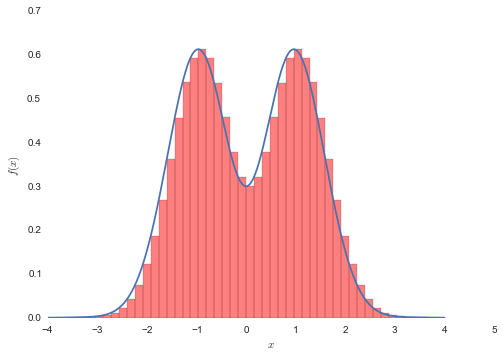

Estimated integral: 1.84 (-0.03% error)


In [14]:
def f(x):
    """ This is the function we want to integrate.
    """
    return (np.sin(x)**2 + 0.3)*np.exp(-0.5*x**2)

def riemann_sum(func, a, b, n):
    """ Approximates an integral using a Riemann sum.
    
            func is the function to be integrated
            a and b are the lower and upper integration limits respectively
            n is the number of rectangles to use in the approximation
    """
    # Values for plotting "exact" function
    x = np.linspace(a, b, 1000)
    f_x = func(x)
        
    # Calculate delta x
    Dx = (float(b) - float(a))/float(n)
    
    # Get a list of x_i
    x_i = np.arange(a, b, Dx)
    
    # Evaluate f(x) at x_i
    f_x_i = func(x_i)
    
    # Evaluate integral
    i_est = (f_x_i*Dx).sum()
    
    # Plot
    plt.plot(x, f_x)
    plt.bar(x_i, f_x_i, width=Dx, alpha=0.5, facecolor='red')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.show()
    
    return i_est

i_true = 1.836 # Analytical solution
i_est = riemann_sum(f, -4, 4, 50)
pct_error = 100*(i_est - i_true)/i_true

print 'Estimated integral: %.2f (%.2f%% error)' % (i_est, pct_error)

For a first attempt the Riemann sum approach does a pretty good job of addressing the two aims listed above: the rectangles give us a kind of "histogram", which gives a pretty good feel for the shape of the function, and by summing their area we can approximate the integral fairly accurately.

Unfortunately this approach does not generalise well for multi-dimensional problems. The one-diminsional example above uses a simple function, which we've integrated over a narrow range of between -4 and 4. In practice, our posterior densities may be very more complex surfaces, and it is not uncommon for uncertainty in parameter ranges in environmental models to vary across several orders of magnitude. Even if we could get away with approximating the integral using just 50 slices *per dimension* (which is unlikely) for a model with ten dimensions the number of function evaluations is $50^{10} \approx 9.8.10^{16}$. How long might this take to run? In the cell below I've streamlined the `riemann_sum` function by removing the code used for plotting. Let's use `%timeit` to see how long the code takes to execute.

In [15]:
def riemann_sum(func, a, b, n):
    """ Approximates an integral using a Riemann sum.
    
            func is the function to be integrated
            a and b are the lower and upper integration limits respectively
            n is the number of rectangles to use in the approximation
    """      
    # Calculate delta x
    Dx = (float(b) - float(a))/float(n)
    
    # Get a list of x_i
    x_i = np.arange(a, b, Dx)
    
    # Evaluate f(x) at x_i
    f_x_i = func(x_i)
    
    # Evaluate integral
    i_est = (f_x_i*Dx).sum()
    
    return i_est

%timeit riemann_sum(f, -4, 4, 50)

10000 loops, best of 3: 33.4 µs per loop


Without worrying too much about the details of exactly what's being timed, or about the possibilities for optimisation etc., on my machine it takes about $30 \; \mu s$ to estimate the one-dimensional integral. If we scale this up to 10 dimensions we might therefore expect a runtime somewhere in the region of around ***1800 years***! Hopefully this is enough to convince you that the Riemann sum approach is not that useful in practice for complex environmental models.

## 2.2. Monte Carlo (MC)

Monte Carlo (MC) is an umbrella term for a whole range of different methods, all of which involve random sampling. One big advantage of MC methods is that their accuracy is **independent of the dimensionality of the space to be sampled**, which represents a big improvement over the Riemann sum approach. MC methods are a huge subject, and we're barely going to scratch the surface here.

### 2.2.1. Integration and expected values

MC methods make use of a conceptual link between sampling theory and integration. If we draw $n$ independent random samples, $x_i$, from a continuous random variable with distribution, $P(x)$, then the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) says that the average of the sample values converges to the **[expected value](https://en.wikipedia.org/wiki/Expected_value)** of the distribution as $n$ tends towards infinity.

For continuous random variables, the expected value, $E[x}$ can also be expressed as an integral

$$E[x] = \int_{-\infty}^{\infty} x P(x) dx$$

Furthermore, the expected value of any function, $g(x)$, given that $x$ has probability density function $P(x)$, can be written as

$$E[g(x)] = \int_{-\infty}^{\infty} g(x) P(x) dx$$

This means that there is a useful link between averages of sampled values and integrals. Suppose we have some function $f(x)$ which we want to integrate

$$I = \int_{-\infty}^{\infty} f(x) dx$$

we can re-write this by multiplying the integrand by some other function $\frac{P(x)}{P(x)}$, where $P(x)$ is any probability density distribution. This is one of those funny mathematical tricks where you multiply something by one, nut in a way that turn out to be useful

$$I = \int_{-\infty}^{\infty} \frac{f(x)}{P(x)} P(x) dx$$

By comparing this equation to the one above, you should be able to see that in this form $I$ is the expected value of $\frac{f(x)}{P(x)}$ with respect to a random variable distributed according to $P(x)$

$$I = E\left[\frac{f(x)}{P(x)}\right]$$

We can estimate $E\left[\frac{f(x)}{P(x)}\right]$ by drawing samples, $x_i$, from $P(x)$, then calculating $\frac{f(x)}{P(x)}$ and averaging the results. This means that as long as we can evaluate $f(x)$ for any $x$, and as long as we choose $P(x)$ to be something we can draw samples from, we can estimate the integral using a simple random sampling strategy.

### 2.2.2. Importance sampling

The first sampling strategy we will consider is **importance sampling**. Note that although this approach provides a method for evaluating integrals (which is one of the aims listed at the start of section 2), it does not allow us to say much about the shape of the posterior distribution (which was our other main motivation for adopting numerical methods). **Rejection sampling** (see below) is a related technique that can do both.

Importance sampling is a direct extension of the discussion above concerning expected values - all we need to do is choose a probability density function, $P(x)$, that we can sample from. But what should we choose? Let's consider the same example that we used above to illustrate the Riemann sum

$$I = \int_{-4}^{4} (\sin^2 x + 0.3)e^{-0.5x^2} dx$$

where we already know that the true value is **$I = 1.836$**. We'll try two different sampling distributions for $P(x)$: a **uniform distribution** between -4 and 4, and a **Gaussian distribution** with mean 0 and a standard deviation of 1.

The three functions - $f(x)$ and the two possibilities for $P(x)$ - are plotted below.

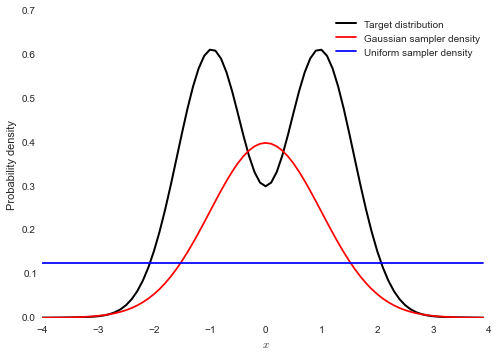

In [16]:
import scipy.stats as stats

def f(x):
    """ This is the function we want to integrate.
    """
    return (np.sin(x)**2 + 0.3)*np.exp(-0.5*x**2)

# The function has an analytical solution in this case, so we'll calculate 
# an exact value to compare out estimates to. 
true_val = 1.836

# Range of x values for plotting
x = np.arange(-4, 4, 0.1)

# We'll try two differing "sampler densities": a uniform distribution and a Gaussian
norm = stats.norm(loc=0, scale=1)          # mu=0 and sd=1
unif = stats.uniform(loc=-4, scale=8)      # min=-4, max=4

# Get densities to plot
sampler_norm = norm.pdf(x)
sampler_unif = unif.pdf(x)
f_x = f(x)

# Plot
plt.plot(x, f_x, 'k-', lw=2, label='Target distribution')
plt.plot(x, sampler_norm, 'r-', label='Gaussian sampler density')
plt.plot(x, sampler_unif, 'b-', label='Uniform sampler density')
plt.xlabel('$x$')
plt.ylabel('Probability density')
plt.legend(loc='best')
plt.show()

Looking at the image above, it is clear that when we draw samples from the uniform distribution, values towards the margins of the plot will be over-represented compared to the target distribution (because $P(x) > f(x)$ in these regions), whereas towards the middle of the range values will be under-represented. To account for this we calculate weights, $\frac{f(x)}{P(x)}$, which we use to adjust the **importance** of each point in our sample.

If our sampling distribution is very ndifferent from the target distribution (as is the case for the uniform distribution in the above example), then the algorithm will draw many points from *unimportant* regions of the parameter space, and for this reason it will take longer to achieve an accurate estimated for the integral. Based on this, we might expect the Gaussian sampler density to perform better than the uniform one, because the Gaussian assigns greater *importance* to roughly the right parts of the parameter space.

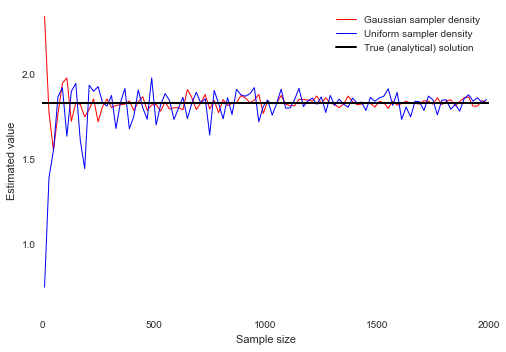

In [17]:
# Importance sampling
# Try a variety of different sample sizes
samp_sizes = range(10, 2000, 20)

# Lists to store results
unif_est = []
norm_est = []

# Loop over sample sizes
for item in samp_sizes:
    # Draw the desired number of samples from the sampler densities
    uni_samp = unif.rvs(item)
    norm_samp = norm.rvs(item)

    # Evaluate p_i and f_i for uniform sampler density 
    p_i_uni = unif.pdf(uni_samp)
    f_i_uni = f(uni_samp)
    
    # Expected value from uniform density
    exptd_uni = (f_i_uni/p_i_uni).mean()
    unif_est.append(exptd_uni)

    # Repeat for Gaussian sampler density
    p_i_norm = norm.pdf(norm_samp)
    f_i_norm = f(norm_samp)
    exptd_norm = (f_i_norm/p_i_norm).mean()
    norm_est.append(exptd_norm)

# Plot results based on different sample sizes and sampler densities
plt.plot(samp_sizes, norm_est, 'r-', lw=1, label='Gaussian sampler density')
plt.plot(samp_sizes, unif_est, 'b-', lw=1, label='Uniform sampler density')
plt.axhline(true_val, lw=2, color='k', label='True (analytical) solution')
plt.xlabel('Sample size')
plt.ylabel('Estimated value')
plt.legend(loc='best')
plt.show()

### 2.2.3. Rejection sampling

Importance sampling only any good for estimating expected values (i.e. integrals). This is helpful in model calibration, as we can now perform the integrals of things that we couldn't otherwise integrate (like marginal densities). However, it would be more useful to have a mtehod that simply generate a representative sample from the posterior. This is more flexinble, and we can marginalise by calculating marginal histograms based on the sample. Rejection sampling does this.

#### Uniform rejection sampling

#### Non-unifrom rejection sampling

A bit like importance sampling in that it focuses attention towards the most important parts of the distribution. Repeat example above. 

### 2.2.4. Performance in high dimensional spaces

Neither methods work well in high D spaces (see MacKay). List some of other difficulties too.

## 2.3. Markov chain Monte Carlo (MCMC)

### 2.3.1. Metropolis algorithm